# Регрессор, для определения положения изображения в мозгу

In [10]:
# %pip install nilearn

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import os
import numpy as np
import nibabel as nib
from nilearn import image
import matplotlib.pyplot as plt

In [12]:
path = r'C:\Users\Анна\Desktop\APPOPLEXY\Lesions\Lesions'
stroke_types = os.listdir(path)
X = []
Y = []
for folder in stroke_types:
    for patient in os.listdir(f'{path}\{folder}'):
        img = nib.load(f'{path}\{folder}\{patient}\dwi.nii.gz')
        if len(img.shape) == 4:
            img = image.index_img(img, 0)
            img_data = img.get_fdata()
            aff = img.affine
            for i in range(img.shape[2]):
                Y.append(round((aff @ np.array([0, 0, i, 1]))[2]))
                X.append(img_data[:, :, i])


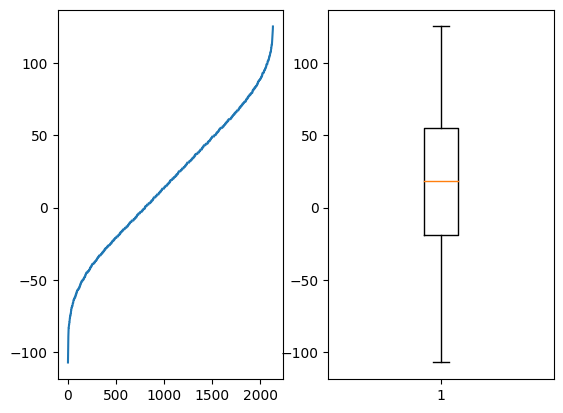

In [13]:
#выбросов не наблюдается
fig, ax = plt.subplots(1, 2)
ax[0].plot(sorted(Y))
ax[1].boxplot(Y)
plt.show()

In [14]:
X = np.array(X)
# нормализуем Y, чтобы не было отрицательных значений
Y -= np.min(Y)
Y = np.array(Y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [15]:
#Конвертируем в тензоры

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [16]:
# создаём датасеты и лоадеры

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

#### Модель

Опираясь вот на эти данные, попробуем использовать VGG-19
https://www.frontiersin.org/articles/10.3389/fnhum.2023.1150120/full


In [17]:
# Define the VGG-19 architecture
class VGG19Regression(nn.Module):
    def __init__(self):
        super(VGG19Regression, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.regression_layer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.regression_layer(x)
        return x




In [18]:
import cv2
import numpy as np

# load image
img = cv2.imread('00a0b3a7e5.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold 
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]



#### Тренировочка

В качестве лосса будем использовать MSE, в качестве оптимизатора - Adam

In [20]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print(device)

model = VGG19().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #обнуляем градиенты
        optimizer.zero_grad()

        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backpropagate
        loss.backward()
        optimizer.step()

        #выведем статистику
        if (batch_idx+1)%10 == 0:
            print(f'Epoch: {epoch+1}/10, Step: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() :.2f}')


cpu


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 64, 256, 256] to have 3 channels, but got 64 channels instead

In [ ]:
#ну и на тесте
with torch.no_grad(): #тут нам градиент не нужен, не тратим на него время
    total_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    mean_loss = total_loss / len(test_loader)
    print(f'Test Loss: {mean_loss:.4f}')

Test Loss: 1124.3539


для conv

In [ ]:
outputs.T.shape

torch.Size([1, 31])

In [ ]:
targets.T

tensor([[197., 133., 194.,  87., 144., 146., 141.,  74., 165., 104., 179., 129.,
         141., 169., 217.,  63., 219.,  77.,  95., 100., 143., 100.,  92., 133.,
         139.,  72.,  74.,  87.,  15.,  66., 119.,  92.]], device='cuda:0')